# Imports

In [1]:
# !pip install PyMuPDF 
# !pip install transformers torch
# !pip install --upgrade ipywidgets

In [2]:
import fitz  # PyMuPDF
import torch
import logging
import spacy
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, TFAutoModel

In [3]:
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

# Loading Text From PDF File

In [4]:
pdf_path = "test article, zakelijke dienstverlening\\test_article_manually_extracted.pdf"
text = extract_text_from_pdf(pdf_path)
print(text)

Ook bij kredietverlening aan het mkb zijn bankpraktijken al jaren 
onacceptabel, en andere lezersreacties 
De lezers van het FD reageren deze week op het discutabele handelen van banken, hoe ‘Made in 
Germany’ verdwijnt, de bittere bijsmaak van graan en een goed getimed rapport. 
 
Vermeende nutsfunctie 
De hoogleraren Arnoud Boot en Harald Benink vragen terecht aandacht voor het discutabele 
optreden van banken (FD, 25 september). Ook bij de kredietverlening aan het mkb zijn bankpraktijken 
al jaren maatschappelijk onacceptabel. Zij verlenen geen krediet meer aan bepaalde sectoren, het 
serviceniveau daalde sterk, de adviesfunctie ontbreekt en zij vragen enorme zekerheden. 
Terwijl de banken zelf zo min mogelijk eigen vermogen willen aanhouden, worden bij bestaande 
klanten de duimschroeven snel aangedraaid als de liquiditeit krapper wordt. Niet omdat banken risico 
dragen, want er zijn immers panden, voorraden en andere tegoeden. Het draait louter om het 
winstgedreven verdienmodel v

# Dataset Construction

In [5]:
directory = 'data'
df = pd.DataFrame(columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])

print('Please ensure that only pdf files of articles are present in the subfolders of the specified directory')
article_nr = 1
for folder in os.listdir(directory):
    folder_size = len(os.listdir(directory + "\\" + folder))
    print(f'{folder_size} article(s) detected in {folder} folder')
    
    for article in os.listdir(directory + '\\' + folder):
        text = extract_text_from_pdf(directory + '\\' + folder + '\\' + article)
        date = article.split(' ')[-1].split('.')[0] #Remove the article number and ".pdf" to obtain the publication date
        
        paragraphs = [para.strip() for para in text.split("\n \n") if para.strip()]
        para_nr = 1
        for para in paragraphs:
            df_temp = pd.DataFrame([[article_nr, para_nr, para, folder, date]], 
                                   columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])
            df = pd.concat([df, df_temp])
            para_nr += 1
        article_nr += 1
        
df.set_index(['article_id' , 'paragraph_id'], inplace=True)
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%d-%m-%Y')

Please ensure that only pdf files of articles are present in the subfolders of the specified directory
26 article(s) detected in Bouw & Vastgoed folder
37 article(s) detected in Handel & Industrie folder
37 article(s) detected in Zakelijke Dienstverlening folder
20 article(s) detected in Zorg folder


In [6]:
df

text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
118        2             Telgenkamp vestigt haar hoop voor de korte ter...   
119        1             Waarom verzekeraars inkomsten uit zwart werk w...   
120        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                   group publication_date  
article_id paragraph_id                                    
1          1             Bouw & Vastgoed       2024-08-28  
           2             Bouw & Vastgoed       2024-08-28  
           3             Bouw & Vastgoed       2024-08-28  
           4             Bouw & Vastgoed       2024-08-28  
           5             Bouw & Vastgoed       2024-08-28  
...                                  ...              ...  
118        2                        Zorg       2024-10-08  
119        1                        Zorg       2024-10-17  
120        1                        Zorg       2024-10-16  
           2                        Zorg       2024-10-16  
           3                        Zorg       2024-10-16  

[374 rows x 3 columns]

In [7]:
for group in df['group'].unique():
    print(f"{len(df[df['group'] == group])} paragraphs in {group}.")

124 paragraphs in Bouw & Vastgoed.
114 paragraphs in Handel & Industrie.
83 paragraphs in Zakelijke Dienstverlening.
53 paragraphs in Zorg.


# Text pre-processing

a pre-processed dataset df_clean is constructed out of df

In [8]:
df_clean = df.copy()
df_clean['original_text'] = df_clean['text'].copy()
df_clean = df_clean[['original_text', 'text', 'group']]

**Case Normalization**: <br>
- Lowercasing
- Replacing \n with '[NEWLINE] ' 
- Removing duplicate spaces

In [9]:
def case_normalization(text):
    """Returns string of input containing only lowercase letters apart from [NEWLINE], which replaces \n"""
    text = text.lower()
    text = text.replace('\n', ' [NEWLINE] ')
    while text != text.replace('  ', ' '):
        text = text.replace('  ', ' ')
    return text

df_clean['text'] = df_clean['text'].apply(case_normalization)

**POS Tagging**. <br>
<br>
There are 2 types of POS tagging: <br>
- Rule-based POS tagging
- Statistical POS tagging 

**Benefits** of **rule-based** Part-of-speech (POS) tagging:
- Simple to implement and understand
- It doesn’t require a lot of computational resources or training data
- It can be easily customized to specific domains or languages

**Disadvantages** of **rule-based** Part-of-speech (POS) tagging:
- Less accurate than statistical taggers
- Limited by the quality and coverage of the rules
- It can be difficult to maintain and update

**Benefits** of **Statistical** Part-of-speech (POS) Tagging:
- More accurate than rule-based taggers
- Don’t require a lot of human-written rules
- Can learn from large amounts of training data

**Disadvantages** of **statistical** Part-of-speech (POS) Tagging:
- Requires more computational resources and training data
- It can be difficult to interpret and debug
- Can be sensitive to the quality and diversity of the training data

I select Statistical POS tagging since the accuracy tends to be higher and since pre-trained POS-models are avilable, the requirement for a lot of training data is no problem. Additionally, the required computational power is no problem due to the small size of the used data for this project. <br>
For more information on the used model, see https://github.com/evanmiltenburg/Dutch-tagger

In [10]:
#Download the Dutch POS model
!python -m spacy download nl_core_news_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.1 MB/s eta 0:00:11
     -- ------------------------------------- 0.8/12.8 MB 1.0 MB/s eta 0:00:12
     --- ------------------------------------ 1.0/12.8 MB 1.1 MB/s eta 0:00:11
     ---- ----------------------------------- 1.3/12.8 MB 1.2 MB/s eta 0:00:10
     ---- ----------------------------------- 1.6/12.8 MB 1.2 MB/s eta 0:00:10
     ----- ---------------------------------- 1.8/12.8 MB 1.2 MB/s eta 0:00:10
     ------ --------------------------------- 2.1/12.8 MB 1.2 MB/s eta 0:00:09
     ------- -------------------------------- 2.4/12.8 MB 1.2 MB/s eta 0:00:09
     -------- ------------------------------- 2.6/12.8 MB 1.2 MB/s eta 0:00:09
     -------- ------------------------------- 2.6/12.8 MB 1.2 MB/s eta 0:00:09
     -------- ------------------------------- 2.9/12.8 MB 1.2 MB/s

In [11]:
# Load the 'en_core_web_sm' model
nlp = spacy.load('nl_core_news_sm')

# Define a sentence
text = "Ik ben een student"

# Process the sentence using spaCy's NLP pipeline
doc = nlp(text)

# Iterate through the token and print the token text and POS tag
for token in doc:
    print(token.text, token.pos_)

Ik PRON
ben AUX
een DET
student NOUN


In [12]:
def POS_tagging(text):
    """Returns a list of (token, POS tag) tuples for the input text"""
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    return pos_tags

df_clean['pos_tags'] = df_clean['text'].apply(POS_tagging)

**Lemmatization**

In [13]:
# Sample text
text = "De katten liepen in de tuin."

# Process the text
doc = nlp(text)

# Print PoS tagging and Lemmatization for each token
print(f"{'Token':<15}{'PoS':<15}{'Lemma':<15}")
print("-" * 45)
for token in doc:
    print(f"{token.text:<15}{token.pos_:<15}{token.lemma_:<15}")

Token          PoS            Lemma          
---------------------------------------------
De             DET            de             
katten         NOUN           kat            
liepen         VERB           liepen         
in             ADP            in             
de             DET            de             
tuin           NOUN           tuin           
.              PUNCT          .              


In [14]:
# nlp = spacy.load("nl_core_news_sm")

special_cases = {"[NEWLINE]": [{"ORTH": "[NEWLINE]"}]}
nlp.tokenizer.add_special_case("[NEWLINE]", [{"ORTH": "[NEWLINE]"}])

doc = nlp(df_clean.loc[(1,1),'text'])

for token in doc:
    print(token.text, token.pos_, token.lemma_)
    print('')

provincies NOUN provincie

willen VERB willen

aan ADP aan

de DET de

slag NOUN slag

met ADP met

versoepeling NOUN versoepeling

stikstofregels NOUN stikstofregels

. PUNCT .

[NEWLINE] NOUN [NEWLINE]

door ADP door

kabinet NOUN kabinet

beoogde VERB beoogen

hogere ADJ hoog

drempelwaarde NOUN drempelwaarde

lijkt VERB lijken

mogelijk ADJ mogelijk

, PUNCT ,

aldus ADV aldus

rapport NOUN rapport

. PUNCT .

[NEWLINE] VERB [NEWLINE]

de DET de

provincies NOUN provincie

willen VERB willen

‘ PUNCT ‘

voortvarend VERB voortvaren

’ PUNCT ’

aan ADP aan

de DET de

slag NOUN slag

met ADP met

de DET de

versoepeling NOUN versoepeling

van ADP van

de DET de

stikstofregels NOUN stikstofregel

[NEWLINE] SYM [NEWLINE]

waarmee ADV waarmee

het DET het

nieuwe ADJ nieuw

kabinet NOUN kabinet

nederland PROPN Nederland

van ADP van

het DET het

slot NOUN slot

wil VERB willen

krijgen VERB krijgen

. PUNCT .

het PRON het

is AUX zijn

aannemelijk ADJ aannemelijk

dat SCONJ dat

een

In [15]:
def lemmatization(df, text_column="text", output_column="text"):
    """Lemmatizes the text in a specified column of a DataFrame and adds the results to a new column."""
    
    # Ensure the input column exists in the DataFrame
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' does not exist in the DataFrame.")
        
    # Apply SpaCy processing and lemmatization
    df[output_column] = df[text_column].apply(
        lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_space]))
    
    return df

df_clean['text before lemmatization'] = df_clean['text'].copy()
df_clean = lemmatization(df_clean, text_column="text")
df_clean

original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
118        2             Telgenkamp vestigt haar hoop voor de korte ter...   
119        1             Waarom verzekeraars inkomsten uit zwart werk w...   
120        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             provincie willen aan de slag met versoepeling ...   
           2             het draaien allemaal om de drempelwaarde voor ...   
           3             met een hoog drempelwaarde zullen weinig vergu...   
           4             in het hoofdlijnenakkoord hebben de vier coali...   
           5             de ondergrens zijn al lang onderwerp van discu...   
...                                                                    ...   
118        2             telgenkamp vestigen haar hoop voor de kort ter...   
119        1             waarom verzekeraar inkomst uit zwart werk wel ...   
120        1             verzekeraar willen klant helpen met zorgbemidd...   
           2             verzekeraar willen wachten patiënt aan snel zo...   
           3             zorgbemiddeling zijn geen wondermiddel maar ku...   

                                   group  \
article_id paragraph_id                    
1          1             Bouw & Vastgoed   
           2             Bouw & Vastgoed   
           3             Bouw & Vastgoed   
           4             Bouw & Vastgoed   
           5             Bouw & Vastgoed   
...                                  ...   
118        2                        Zorg   
119        1                        Zorg   
120        1                        Zorg   
           2                        Zorg   
           3                        Zorg   

                                                                  pos_tags  \
article_id paragraph_id                                                      
1          1             [(provincies, NOUN), (willen, VERB), (aan, ADP...   
           2             [(het, PRON), (draait, VERB), (allemaal, ADV),...   
           3             [(met, ADP), (een, DET), (hogere, ADJ), (dremp...   
           4             [(in, ADP), (het, DET), (hoofdlijnenakkoord, N...   
           5             [(de, DET), (ondergrens, NOUN), (is, AUX), (al...   
...                                                                    ...   
118        2             [(telgenkamp, NOUN), (vestigt, VERB), (haar, P...   
119        1             [(waarom, ADV), (verzekeraars, NOUN), (inkomst...   
120        1             [(verzekeraar, NOUN), (wil, VERB), (klant, NOU...   
           2             [(verzekeraar, NOUN), (wil, VERB), (wachtende,...   
           3             [(zorgbemiddeling, NOUN), (is, AUX), (geen, DE...   

                                                 text before lemmatization  
article_id paragraph_id                                                     
1          1             provincies willen aan de slag met versoepeling...  
           2             het draait allemaal om de drempelwaarde voor e...  
           3             met een hogere drempelwaarde zouden minder ver...  
           4             in het hoofdlijnenakkoord hebben 

**Punctuation Removal**

In [16]:
def remove_punctuation(text):
    """Returns the input text with all punctuation removed"""
    
    text = text.translate(text.maketrans("", "", string.punctuation))
    text = text.replace("NEWLINE", "[NEWLINE]")
    return text

df_clean['text'] = df_clean['text'].apply(remove_punctuation)

**Stop Word Removal**

In [17]:
# Sample text
text = "De snelle bruine vos springt over de luie hond."

# Process the text using spaCy
doc = nlp(text)

# Filter out stopwords
filtered_words = [token.text for token in doc if not token.is_stop]

# Join the filtered words back into a single string
text = " ".join(filtered_words)

# Print the result
print(text)

snelle bruine vos springt luie hond .


In [18]:
def remove_stopwords(text):
    """Returns string of input text with stopwords removed"""
    
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    text = " ".join(filtered_words)
    return text
    
    
# nlp = spacy.load("nl_core_news_sm")
df_clean['text'] = df_clean['text'].apply(remove_stopwords)

**POS Normalization**

In [19]:
#For now, we do not implement this since it clashes with NER. 
#If we need to reduce the dimension of the data, we can implement it later

**Dependency Parsing**

In [20]:
#May overcomplicate the data, check if it improves performance

**NER**

**Stemming** (Altenative for Lemmatization. Check when this should be done in the pre-processing pipeline)

**Resulting DataFrame**

In [21]:
df_clean

original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
118        2             Telgenkamp vestigt haar hoop voor de korte ter...   
119        1             Waarom verzekeraars inkomsten uit zwart werk w...   
120        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             provincie willen slag versoepeling stikstofreg...   
           2             draaien allemaal drempelwaarde stikstofvergunn...   
           3             hoog drempelwaarde vergunning [NEWLINE] aanvec...   
           4             hoofdlijnenakkoord vier coalitiepartij afsprek...   
           5             ondergrens onderwerp discussie huidig Nederlan...   
...                                                                    ...   
118        2             telgenkamp vestigen hoop kort termijn twee cru...   
119        1             verzekeraar inkomst zwart werk vergoeden [NEWL...   
120        1             verzekeraar willen klant helpen zorgbemiddelin...   
           2             verzekeraar willen wachten patiënt snel zorg h...   
           3             zorgbemiddeling wondermiddel helpen zeggen Haa...   

                                   group  \
article_id paragraph_id                    
1          1             Bouw & Vastgoed   
           2             Bouw & Vastgoed   
           3             Bouw & Vastgoed   
           4             Bouw & Vastgoed   
           5             Bouw & Vastgoed   
...                                  ...   
118        2                        Zorg   
119        1                        Zorg   
120        1                        Zorg   
           2                        Zorg   
           3                        Zorg   

                                                                  pos_tags  \
article_id paragraph_id                                                      
1          1             [(provincies, NOUN), (willen, VERB), (aan, ADP...   
           2             [(het, PRON), (draait, VERB), (allemaal, ADV),...   
           3             [(met, ADP), (een, DET), (hogere, ADJ), (dremp...   
           4             [(in, ADP), (het, DET), (hoofdlijnenakkoord, N...   
           5             [(de, DET), (ondergrens, NOUN), (is, AUX), (al...   
...                                                                    ...   
118        2             [(telgenkamp, NOUN), (vestigt, VERB), (haar, P...   
119        1             [(waarom, ADV), (verzekeraars, NOUN), (inkomst...   
120        1             [(verzekeraar, NOUN), (wil, VERB), (klant, NOU...   
           2             [(verzekeraar, NOUN), (wil, VERB), (wachtende,...   
           3             [(zorgbemiddeling, NOUN), (is, AUX), (geen, DE...   

                                                 text before lemmatization  
article_id paragraph_id                                                     
1          1             provincies willen aan de slag met versoepeling...  
           2             het draait allemaal om de drempelwaarde voor e...  
           3             met een hogere drempelwaarde zouden minder ver...  
           4             in het hoofdlijnenakkoord hebben 

# Vector Transformation

For now, I only test TF-IDF

In [22]:
# Extract features and labels
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

In [23]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
X_train_tfidf

<261x6252 sparse matrix of type '<class 'numpy.float64'>'
	with 19106 stored elements in Compressed Sparse Row format>

In [26]:
X_val_tfidf

<56x6252 sparse matrix of type '<class 'numpy.float64'>'
	with 3609 stored elements in Compressed Sparse Row format>

In [27]:
X_test_tfidf

<57x6252 sparse matrix of type '<class 'numpy.float64'>'
	with 3340 stored elements in Compressed Sparse Row format>

# Random Forest Classifier

In [28]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train_tfidf, y_train)
    val_score = classifier.score(X_val_tfidf, y_val)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(X_train_tfidf, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Depth: 5, Validation Score: 0.6607142857142857
Depth: 10, Validation Score: 0.6785714285714286
Depth: 15, Validation Score: 0.7321428571428571
Depth: 20, Validation Score: 0.6964285714285714
Depth: 25, Validation Score: 0.6785714285714286
Depth: None, Validation Score: 0.6607142857142857

Best Depth: 15, Best Validation Score: 0.7321428571428571

Test Accuracy: 0.5614035087719298

Test Classification Report:
                            precision    recall  f1-score   support

          Bouw & Vastgoed       0.68      0.71      0.70        21
       Handel & Industrie       0.53      0.59      0.56        17
Zakelijke Dienstverlening       0.38      0.50      0.43        10
                     Zorg       0.67      0.22      0.33         9

                 accuracy                           0.56        57
                macro avg       0.56      0.51      0.51        57
             weighted avg       0.58      0.56      0.55        57



Now we show the accuracy per class and visualize them as a confusion matrix

In [29]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.7143
Class 'Handel & Industrie' Accuracy: 0.5882
Class 'Zakelijke Dienstverlening' Accuracy: 0.5000
Class 'Zorg' Accuracy: 0.2222


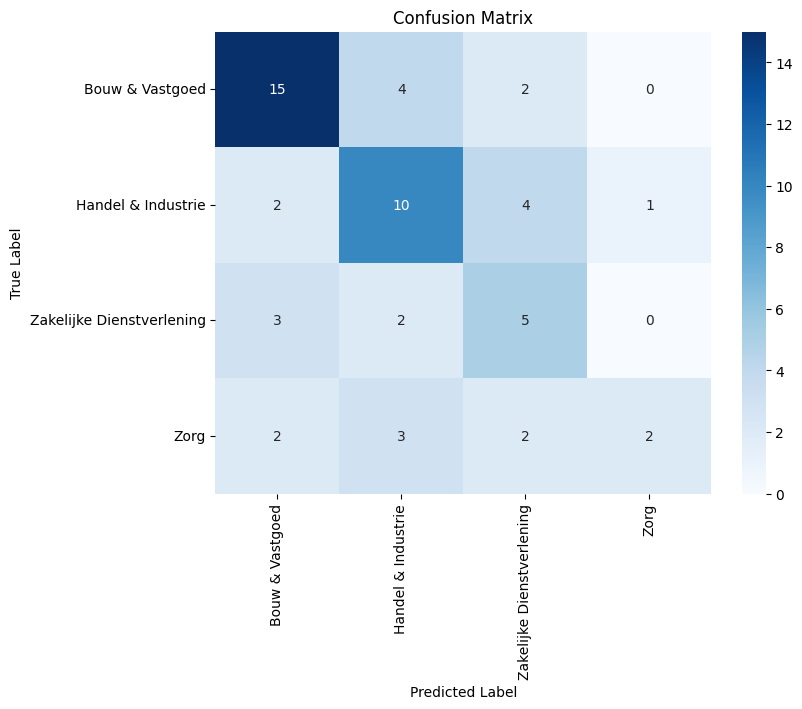

In [30]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Support Vector Machine

In [31]:
# Tune the SVM hyperparameters using the validation set
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_tfidf, y_train)
        val_score = classifier.score(X_val_tfidf, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_tfidf, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.375
Kernel: linear, C: 1, Validation Score: 0.8035714285714286
Kernel: linear, C: 10, Validation Score: 0.7678571428571429
Kernel: rbf, C: 0.1, Validation Score: 0.375
Kernel: rbf, C: 1, Validation Score: 0.6785714285714286
Kernel: rbf, C: 10, Validation Score: 0.75
Kernel: poly, C: 0.1, Validation Score: 0.375
Kernel: poly, C: 1, Validation Score: 0.625
Kernel: poly, C: 10, Validation Score: 0.6428571428571429

Best Kernel: linear, Best C: 1, Best Validation Score: 0.8035714285714286

Test Accuracy: 0.7368421052631579

Test Classification Report:
                            precision    recall  f1-score   support

          Bouw & Vastgoed       0.88      0.71      0.79        21
       Handel & Industrie       0.67      0.82      0.74        17
Zakelijke Dienstverlening       0.58      0.70      0.64        10
                     Zorg       0.86      0.67      0.75         9

                 accuracy                           0.74        

Now we show the accuracy per class and visualize them as a confusion matrix

In [32]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.7143
Class 'Handel & Industrie' Accuracy: 0.8235
Class 'Zakelijke Dienstverlening' Accuracy: 0.7000
Class 'Zorg' Accuracy: 0.6667


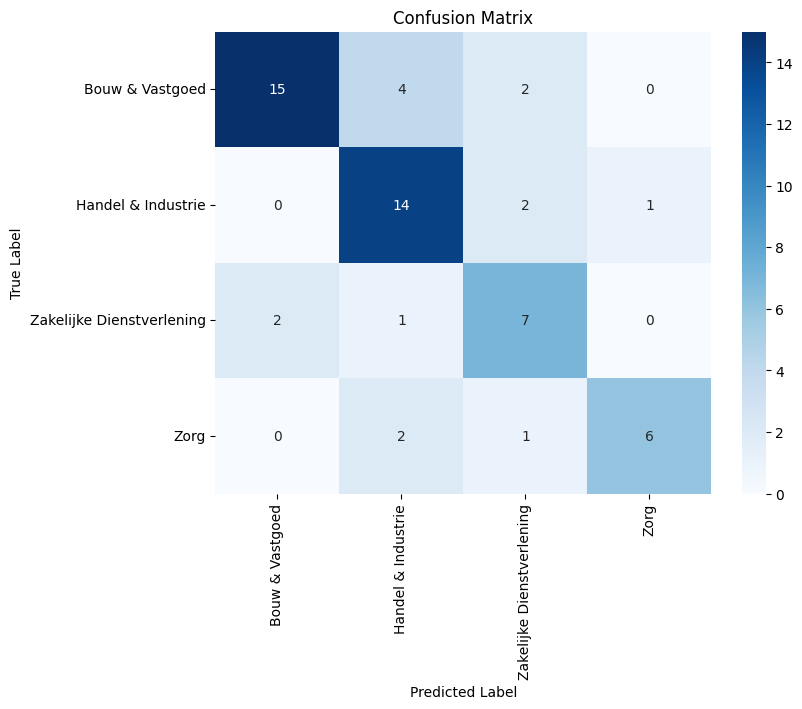

In [33]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Naive Bayes

In [34]:
# Tune the Naive Bayes hyperparameters using the validation set
best_alpha = None
best_fit_prior = None
best_score = float('-inf')

# Test different hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]

for fit_prior_value in fit_prior_values:
    for alpha in alpha_values:
        classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
        classifier.fit(X_train_tfidf, y_train)
        val_score = classifier.score(X_val_tfidf, y_val)
        print(f"Alpha: {alpha}, fit_prior: {fit_prior_value}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_alpha = alpha
            best_fit_prior = fit_prior_value

print(f"\nBest alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best Validation Score: {best_score}")

# Train the final model using the best alpha and fit_prior
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Alpha: 0.01, fit_prior: True, Validation Score: 0.7678571428571429
Alpha: 0.1, fit_prior: True, Validation Score: 0.8035714285714286
Alpha: 0.5, fit_prior: True, Validation Score: 0.7142857142857143
Alpha: 1.0, fit_prior: True, Validation Score: 0.6428571428571429
Alpha: 2.0, fit_prior: True, Validation Score: 0.625
Alpha: 5.0, fit_prior: True, Validation Score: 0.5535714285714286
Alpha: 10.0, fit_prior: True, Validation Score: 0.5178571428571429
Alpha: 0.01, fit_prior: False, Validation Score: 0.7678571428571429
Alpha: 0.1, fit_prior: False, Validation Score: 0.7678571428571429
Alpha: 0.5, fit_prior: False, Validation Score: 0.7857142857142857
Alpha: 1.0, fit_prior: False, Validation Score: 0.75
Alpha: 2.0, fit_prior: False, Validation Score: 0.7321428571428571
Alpha: 5.0, fit_prior: False, Validation Score: 0.5714285714285714
Alpha: 10.0, fit_prior: False, Validation Score: 0.5178571428571429

Best alpha: 0.1, Best fit_prior: True, Best Validation Score: 0.8035714285714286

Test Accu

Now we show the accuracy per class and visualize them as a confusion matrix

In [35]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.6190
Class 'Handel & Industrie' Accuracy: 0.8235
Class 'Zakelijke Dienstverlening' Accuracy: 1.0000
Class 'Zorg' Accuracy: 0.7778


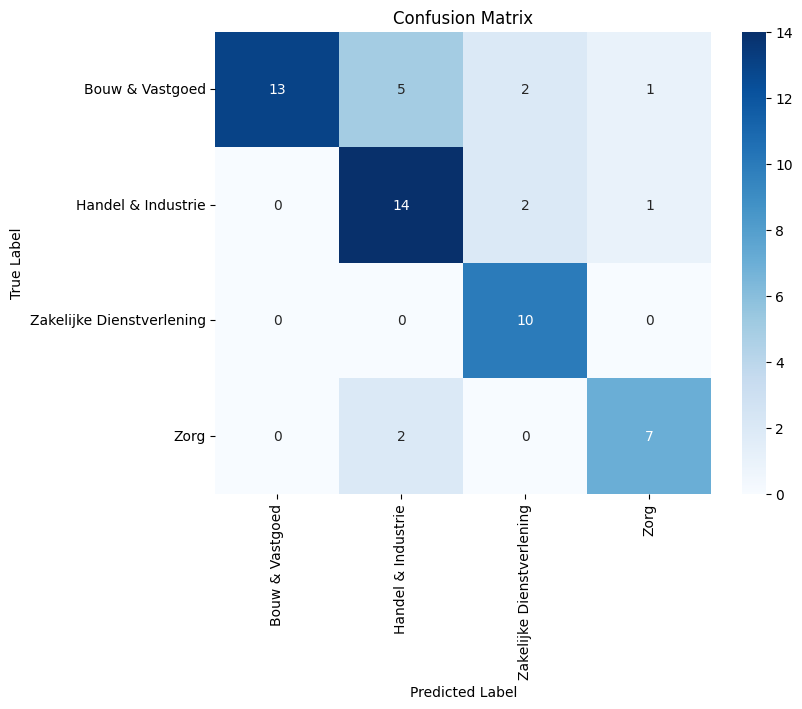

In [36]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Leave-one-out cross validation

In [37]:
# Extract features and labels
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

# Split the data into training (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Hyperparameter tuning with LOO-CV
best_alpha = None
best_fit_prior = None
best_score = float('-inf')

# Define hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]

# Try different hyperparameter combinations
for fit_prior_value in fit_prior_values:
    for alpha in alpha_values:
        scores = []
        
        for train_index, val_index in loo.split(X_train_tfidf):
            X_train_cv, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
            y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            
            classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
            classifier.fit(X_train_cv, y_train_cv)
            
            y_pred = classifier.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
        
        mean_score = np.mean(scores)
        print(f"Alpha: {alpha}, fit_prior: {fit_prior_value}, LOO-CV Score: {mean_score}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha
            best_fit_prior = fit_prior_value

print(f"\nBest alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best LOO-CV Score: {best_score}")

# Train the final model using the best hyperparameters
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Evaluate on the test set
y_pred = final_classifier.predict(X_test_tfidf)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Alpha: 0.01, fit_prior: True, LOO-CV Score: 0.722397476340694
Alpha: 0.1, fit_prior: True, LOO-CV Score: 0.7129337539432177
Alpha: 0.5, fit_prior: True, LOO-CV Score: 0.6624605678233438
Alpha: 1.0, fit_prior: True, LOO-CV Score: 0.5867507886435331
Alpha: 2.0, fit_prior: True, LOO-CV Score: 0.5488958990536278
Alpha: 5.0, fit_prior: True, LOO-CV Score: 0.5331230283911672
Alpha: 10.0, fit_prior: True, LOO-CV Score: 0.5141955835962145
Alpha: 0.01, fit_prior: False, LOO-CV Score: 0.7066246056782335
Alpha: 0.1, fit_prior: False, LOO-CV Score: 0.7160883280757098
Alpha: 0.5, fit_prior: False, LOO-CV Score: 0.7097791798107256
Alpha: 1.0, fit_prior: False, LOO-CV Score: 0.7003154574132492
Alpha: 2.0, fit_prior: False, LOO-CV Score: 0.6624605678233438
Alpha: 5.0, fit_prior: False, LOO-CV Score: 0.5993690851735016
Alpha: 10.0, fit_prior: False, LOO-CV Score: 0.5425867507886435

Best alpha: 0.01, Best fit_prior: True, Best LOO-CV Score: 0.722397476340694

Test Accuracy: 0.7368421052631579

Test Cla

In [38]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.7083
Class 'Handel & Industrie' Accuracy: 0.8824
Class 'Zakelijke Dienstverlening' Accuracy: 0.6250
Class 'Zorg' Accuracy: 0.6250


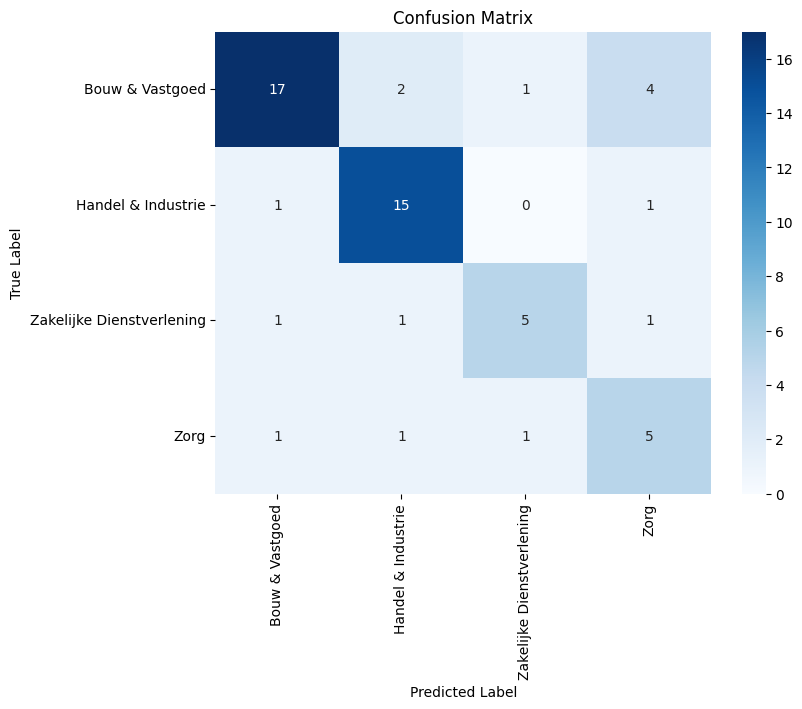

In [39]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [40]:
# This leads to worse performance. Likely since Leave-one-out cross validation tends to create High-Variance Models.
# Instead, I will use stratified K-fold cross validation. K will be treated as a hyperparameter.

In [41]:
# Extract features and labels
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

# Split the data into training (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter tuning with Stratified K-Fold CV
best_alpha = None
best_fit_prior = None
best_k = None
best_score = float('-inf')

# Define hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]
k_values = [2, 3, 5, 10, 20]  # Different values for K in StratifiedKFold

# Try different hyperparameter combinations
for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    for fit_prior_value in fit_prior_values:
        for alpha in alpha_values:
            scores = []
            
            for train_index, val_index in skf.split(X_train_tfidf, y_train):
                X_train_cv, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
                y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                classifier.fit(X_train_cv, y_train_cv)
                
                y_pred = classifier.predict(X_val)
                scores.append(accuracy_score(y_val, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_alpha = alpha
                best_fit_prior = fit_prior_value
                best_k = k

print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")

# Train the final model using the best hyperparameters
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Evaluate on the test set
y_pred = final_classifier.predict(X_test_tfidf)
y_pred_prob = final_classifier.predict_proba(X_test_tfidf)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

K: 2, Alpha: 0.01, fit_prior: True, StratifiedKFold Score: 0.6844996417482685
K: 2, Alpha: 0.1, fit_prior: True, StratifiedKFold Score: 0.6971777724703447
K: 2, Alpha: 0.5, fit_prior: True, StratifiedKFold Score: 0.5868163362789587
K: 2, Alpha: 1.0, fit_prior: True, StratifiedKFold Score: 0.5394474962184539
K: 2, Alpha: 2.0, fit_prior: True, StratifiedKFold Score: 0.5331780909163284
K: 2, Alpha: 5.0, fit_prior: True, StratifiedKFold Score: 0.5174946262240268
K: 2, Alpha: 10.0, fit_prior: True, StratifiedKFold Score: 0.46399570097922144
K: 2, Alpha: 0.01, fit_prior: False, StratifiedKFold Score: 0.6592627975479659
K: 2, Alpha: 0.1, fit_prior: False, StratifiedKFold Score: 0.709716583074596
K: 2, Alpha: 0.5, fit_prior: False, StratifiedKFold Score: 0.70030252368442
K: 2, Alpha: 1.0, fit_prior: False, StratifiedKFold Score: 0.6688161770559669
K: 2, Alpha: 2.0, fit_prior: False, StratifiedKFold Score: 0.6214473369954621
K: 2, Alpha: 5.0, fit_prior: False, StratifiedKFold Score: 0.558335323

In [42]:
y_pred_prob

for row in y_pred_prob:
    formatted_row = ["{:.4f}".format(val) for val in row]
    print(formatted_row)

['0.6185', '0.0045', '0.3673', '0.0097']
['0.0036', '0.0028', '0.0081', '0.9856']
['0.9990', '0.0002', '0.0004', '0.0004']
['0.0000', '1.0000', '0.0000', '0.0000']
['0.0001', '0.1926', '0.8073', '0.0000']
['0.0308', '0.3067', '0.1775', '0.4850']
['0.0002', '0.0002', '0.9994', '0.0002']
['0.0009', '0.9963', '0.0023', '0.0005']
['0.0717', '0.3571', '0.4697', '0.1016']
['0.0003', '0.0008', '0.9971', '0.0017']
['0.9910', '0.0048', '0.0008', '0.0034']
['0.0001', '0.1926', '0.8073', '0.0000']
['0.0154', '0.1764', '0.2771', '0.5311']
['0.0130', '0.6570', '0.1053', '0.2246']
['0.0156', '0.0648', '0.9173', '0.0023']
['0.0009', '0.9816', '0.0166', '0.0009']
['0.0003', '0.9970', '0.0019', '0.0008']
['0.7661', '0.1392', '0.0882', '0.0065']
['0.0038', '0.7903', '0.1837', '0.0222']
['0.1277', '0.1417', '0.6768', '0.0538']
['0.0009', '0.9905', '0.0077', '0.0009']
['0.9967', '0.0018', '0.0006', '0.0010']
['0.0015', '0.9884', '0.0050', '0.0051']
['0.0002', '0.0025', '0.0038', '0.9935']
['0.9609', '0.00

In [43]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.8421
Class 'Handel & Industrie' Accuracy: 0.7647
Class 'Zakelijke Dienstverlening' Accuracy: 0.6154
Class 'Zorg' Accuracy: 0.7500


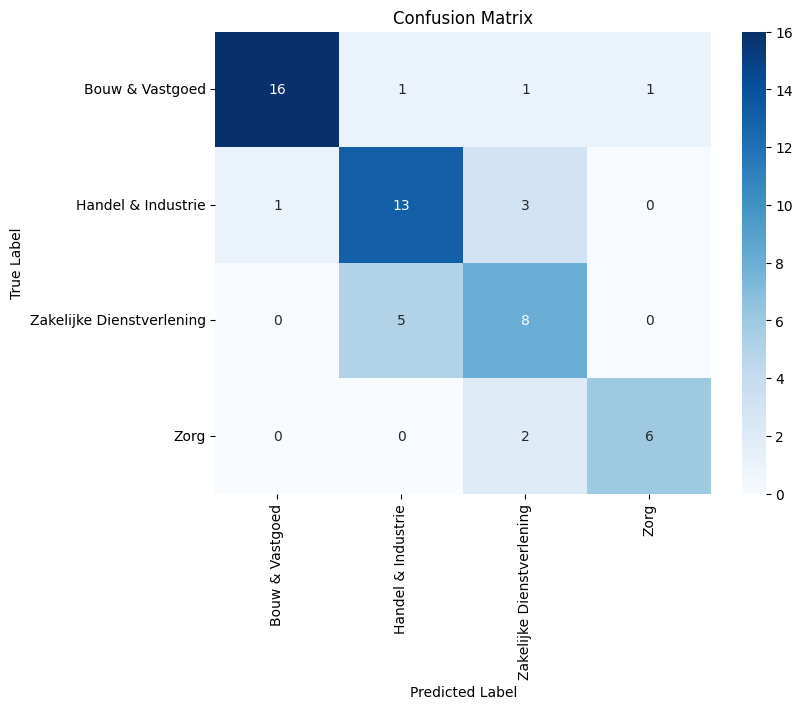

In [44]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [45]:
#Note, need to ensure TF-IDF vectorization happens within each fold to prevent leakage.

# TF-IDF vectorization within folds to avoid data leakage

Currently, vectorizations occurs over the full training set. <br>
However, we train K models, 1 for each fold. <br>
This means that for each fold, vectorizations should occur for the training data for that specific fold. <br>
This avoids data leakage from our validation set to our training set. <br>
Note that this is not strictly needed (since not separately within each fold is usually acceptable), but it should slightly improve performance at the cost of additional runtime.

In [46]:
# Assume df_clean is already defined with 'text' and 'group' columns
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

# Split the data into training (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Hyperparameter tuning with Stratified K-Fold CV
best_alpha = None
best_fit_prior = None
best_k = None
best_score = float('-inf')

# Define hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]
k_values = [2, 3, 5, 10, 20]  # Different values for K in StratifiedKFold

# Try different hyperparameter combinations
for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    for fit_prior_value in fit_prior_values:
        for alpha in alpha_values:
            scores = []
            
            for train_index, val_index in skf.split(X_train, y_train):
                # Split the raw text data for the current fold
                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                # Vectorize within the fold: fit on training fold, transform validation fold
                vectorizer = TfidfVectorizer(max_features=10000)
                X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                X_val_fold_tfidf = vectorizer.transform(X_val_fold)
                
                # Initialize and train the classifier
                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                classifier.fit(X_train_fold_tfidf, y_train_fold)
                
                # Validate the model
                y_pred = classifier.predict(X_val_fold_tfidf)
                scores.append(accuracy_score(y_val_fold, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_alpha = alpha
                best_fit_prior = fit_prior_value
                best_k = k

print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")

# Final model training on the entire training set using the best hyperparameters
# Here, we fit the vectorizer on the full training set
final_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = final_vectorizer.fit_transform(X_train)
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Transform the test set using the vectorizer fitted on the entire training set
X_test_tfidf = final_vectorizer.transform(X_test)
y_pred = final_classifier.predict(X_test_tfidf)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

K: 2, Alpha: 0.01, fit_prior: True, StratifiedKFold Score: 0.7159859883767216
K: 2, Alpha: 0.1, fit_prior: True, StratifiedKFold Score: 0.7034869835204203
K: 2, Alpha: 0.5, fit_prior: True, StratifiedKFold Score: 0.5900007961149589
K: 2, Alpha: 1.0, fit_prior: True, StratifiedKFold Score: 0.5552105724066555
K: 2, Alpha: 2.0, fit_prior: True, StratifiedKFold Score: 0.5426120531804792
K: 2, Alpha: 5.0, fit_prior: True, StratifiedKFold Score: 0.5269086856142027
K: 2, Alpha: 10.0, fit_prior: True, StratifiedKFold Score: 0.49548204760767456
K: 2, Alpha: 0.01, fit_prior: False, StratifiedKFold Score: 0.7064923174906457
K: 2, Alpha: 0.1, fit_prior: False, StratifiedKFold Score: 0.7128612371626463
K: 2, Alpha: 0.5, fit_prior: False, StratifiedKFold Score: 0.6939734097603694
K: 2, Alpha: 1.0, fit_prior: False, StratifiedKFold Score: 0.6530531008677654
K: 2, Alpha: 2.0, fit_prior: False, StratifiedKFold Score: 0.6119735689833612
K: 2, Alpha: 5.0, fit_prior: False, StratifiedKFold Score: 0.555190

# Turning model tuning into function

Since the process of tuning a classifier tends to not change much, we create a function for every type of classifier so that we can tune them without needing to re-write the code every time.

In [133]:
def tune_random_forest(df: pd.DataFrame,
                       testing_ratio: float = 0.15, 
                       vectorization_within_folds: bool = False,
                       k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the Random Forest using stratified K-fold cross validation
    best_depth = None
    best_score = 0
    depth_values = [5, 10, 15, 20, 25, None]  # Different depths to test
    # depth_values = [5, 10]  # For faster tests
    
    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for depth in depth_values:
                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_tfidf, y_train)
                y_pred = classifier.predict(X_val_tfidf)
                mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                print(f"K: {k}, Depth: {depth}, Validation Accuracy: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_depth = depth
                    best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
        
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for depth in depth_values:
            scores = []

            if vectorization_within_folds:
                for train_index, val_index in skf.split(X_train, y_train):
                    # Split the raw text data for the current fold
                    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                vectorizer = TfidfVectorizer(max_features=10000)
                X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                X_val_fold_tfidf = vectorizer.transform(X_val_fold)

                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_fold_tfidf, y_train_fold)
                y_pred = classifier.predict(X_val_fold_tfidf)

            if not vectorization_within_folds:
                for train_index, val_index in skf.split(X_train_tfidf, y_train):
                    X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_fold, y_train_fold)
                y_pred = classifier.predict(X_val_fold)
                    
            scores.append(accuracy_score(y_val_fold, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Depth: {depth}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_depth = depth
                best_k = k
    
    print(f"\nBest K: {best_k}, Best depth: {best_depth}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

In [131]:
def tune_SVM(df: pd.DataFrame,
             testing_ratio: float = 0.15, 
             vectorization_within_folds: bool = False,
             k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_kernel = None
    best_C = None
    best_score = 0
    
    kernels = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]    

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for C in C_values:
                for kernel in kernels:
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_tfidf, y_train)
                    y_pred = classifier.predict(X_val_tfidf)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, C: {C}, Kernel: {kernel}, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_C = C
                        best_kernel = kernel
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for C in C_values:
            for kernel in kernels:
                scores = []
    
                if vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train, y_train):
                        # Split the raw text data for the current fold
                        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
                    vectorizer = TfidfVectorizer(max_features=10000)
                    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                    X_val_fold_tfidf = vectorizer.transform(X_val_fold)
    
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_fold_tfidf, y_train_fold)
                    y_pred = classifier.predict(X_val_fold_tfidf)
    
                if not vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train_tfidf, y_train):
                        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                    
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_fold, y_train_fold)
                    y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, C: {C}, Kernel: {kernel}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_C = C
                    best_kernel = kernel
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best C: {best_C}, Best kernel: {best_kernel}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

In [140]:
def tune_naive_bayes(df: pd.DataFrame,
                     testing_ratio: float = 0.15, 
                     vectorization_within_folds: bool = False,
                     k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_alpha = None
    best_fit_prior = None
    best_score = 0
    
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    fit_prior_values = [True, False]  

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for alpha in alpha_values:
                for fit_prior_value in fit_prior_values:
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_tfidf, y_train)
                    y_pred = classifier.predict(X_val_tfidf)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_alpha = alpha
                        best_fit_prior = fit_prior_value
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for alpha in alpha_values:
            for fit_prior_value in fit_prior_values:
                scores = []
    
                if vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train, y_train):
                        # Split the raw text data for the current fold
                        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
                    vectorizer = TfidfVectorizer(max_features=10000)
                    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                    X_val_fold_tfidf = vectorizer.transform(X_val_fold)
    
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_fold_tfidf, y_train_fold)
                    y_pred = classifier.predict(X_val_fold_tfidf)
    
                if not vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train_tfidf, y_train):
                        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                    
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_fold, y_train_fold)
                    y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_alpha = alpha
                    best_fit_prior = fit_prior_value
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

# Overarching Model Selection Function

Expected parameter values: <br>
> - _classifier_: Selects the type of classifier from amongst the following: ["SVM", "NB", "RF"].
> - _testing_ratio_: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> > Note that if $k=1$, the size of the validation set is assumed to be equal to the size of the testing set, specified by _testing_ratio_.
> - _vectorization_within_folds_: Would you like to vectorize each individual fold rather than vectorizing the entire training set once? [True, False].
> - _show_class_accuracy_: Would you like the accuracy per class to be displayed? [True, False].
> - _show_confusion_matrix_: Would you like the resulting confusion matrix to be displayed? [True, False].
> - _k_values_: All values of k which are tested for stratified k-fold cross validation. Any list containing only positive integers.

In [149]:
def train_model(df: pd.DataFrame,
                model_type: str = "SVM", 
                testing_ratio: float = 0.15, 
                vectorization_within_folds: bool = False, 
                show_class_accuracy: bool = True, 
                show_confusion_matrix: bool = True,
                k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    print(f"Tuning {model_type} classifier with a train/test split of {1-testing_ratio}/{testing_ratio} \n")
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if model_type not in ["SVM", "NB", "RF"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'NB', 'RF'}")
    if testing_ratio < 0 or testing_ratio > 1:
        raise ValueError(f"Invalid testing ratio. Choose a value in the inclusive interval [0,1]")
    if type(vectorization_within_folds) != bool:
        raise ValueError(f"Invalid vectorization_within_folds value. Please ensure vectorization_within_folds is boolean")
    if type(show_class_accuracy) != bool:
        raise ValueError(f"Invalid show_class_accuracy value. Please ensure show_class_accuracy is boolean")
    if type(show_confusion_matrix) != bool:
        raise ValueError(f"Invalid show_confusion_matrix value. Please ensure show_confusion_matrix is boolean")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if 1 in k_values and vectorization_within_folds:
        raise ValueError(f"If k_values contains 1, vectorization_within_folds must be False since k=1 implies standard hold-out cross-validation, for which vectorization_within_folds must be False")

    model_mapping = {"SVM": SVC, "NB": MultinomialNB , "RF": RandomForestClassifier}
    ModelClass = model_mapping[model_type]
    
    #Best classifier performance and number of stratified folds so far
    best_score = 0
    best_k = None

    #RF hyperparameters:
    best_depth = None
    depth_values = [5, 10, 15, 20, 25, None]

    #SVM hyperparameters:
    best_kernel = None
    best_C = None
    kernel_values = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]

    #NB hyperparameters:
    best_alpha = None
    best_fit_prior = None
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    fit_prior_values = [True, False]
    
    if model_type == "SVM":
        results = tune_SVM(df=df, testing_ratio=testing_ratio, vectorization_within_folds=vectorization_within_folds, k_values=k_values)
        classifier, y_pred = results[0], results[3]

    if model_type == "NB":
        results = tune_naive_bayes(df=df, testing_ratio=testing_ratio, vectorization_within_folds=vectorization_within_folds, k_values=k_values)
        classifier, y_pred = results[0], results[3]

    if model_type == "RF":
        results = tune_random_forest(df=df, testing_ratio=testing_ratio, vectorization_within_folds=vectorization_within_folds, k_values=k_values)
        classifier, y_pred = results[0], results[3]
    
    if show_class_accuracy:
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred)
        class_names = np.unique(y_test)
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()

# Testing Function

The code below serves only to test the _train_model_ function and to detect and remove bugs. <br>
The specific parameter values hold no significance.

Tuning RF classifier with a train/test split of 0.85/0.15 

K: 2, Depth: 5, StratifiedKFold Score: 0.4810126582278481
K: 2, Depth: 10, StratifiedKFold Score: 0.5126582278481012
K: 2, Depth: 15, StratifiedKFold Score: 0.5
K: 2, Depth: 20, StratifiedKFold Score: 0.5126582278481012
K: 2, Depth: 25, StratifiedKFold Score: 0.5063291139240507
K: 2, Depth: None, StratifiedKFold Score: 0.4936708860759494
K: 3, Depth: 5, StratifiedKFold Score: 0.44761904761904764
K: 3, Depth: 10, StratifiedKFold Score: 0.47619047619047616
K: 3, Depth: 15, StratifiedKFold Score: 0.47619047619047616
K: 3, Depth: 20, StratifiedKFold Score: 0.4666666666666667
K: 3, Depth: 25, StratifiedKFold Score: 0.47619047619047616
K: 3, Depth: None, StratifiedKFold Score: 0.45714285714285713
K: 5, Depth: 5, StratifiedKFold Score: 0.47619047619047616
K: 5, Depth: 10, StratifiedKFold Score: 0.47619047619047616
K: 5, Depth: 15, StratifiedKFold Score: 0.4603174603174603
K: 5, Depth: 20, StratifiedKFold Score: 0.49206349206349204
K:

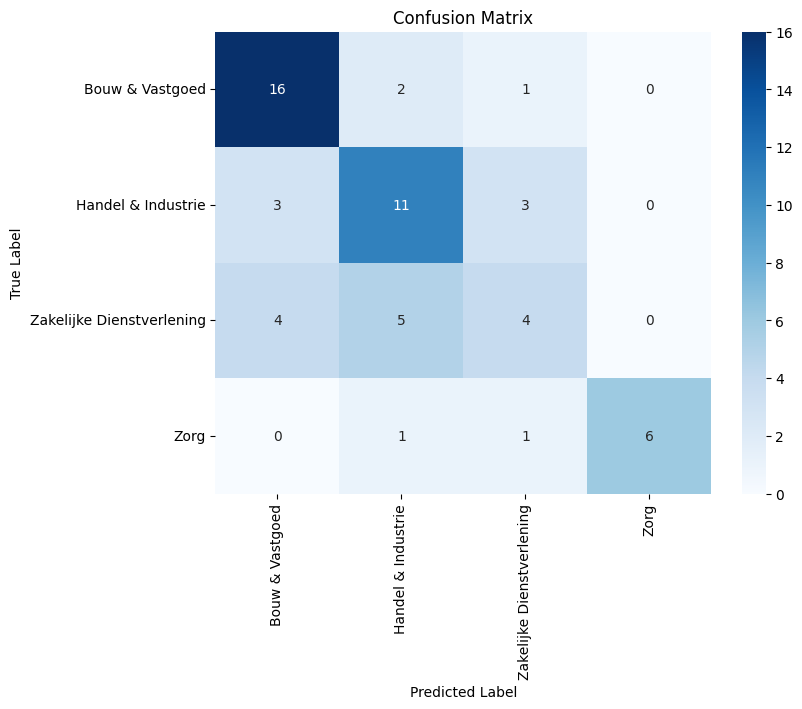

In [150]:
train_model(df=df_clean,
            model_type = "RF", 
            testing_ratio = 0.15, 
            vectorization_within_folds = False, 
            show_class_accuracy = True, 
            show_confusion_matrix = True)

Tuning SVM classifier with a train/test split of 0.85/0.15 

K: 1, C: 0.1, Kernel: linear, Validation Accuracy: 0.375
K: 1, C: 0.1, Kernel: rbf, Validation Accuracy: 0.375
K: 1, C: 0.1, Kernel: poly, Validation Accuracy: 0.375
K: 1, C: 1, Kernel: linear, Validation Accuracy: 0.8035714285714286
K: 1, C: 1, Kernel: rbf, Validation Accuracy: 0.6785714285714286
K: 1, C: 1, Kernel: poly, Validation Accuracy: 0.625
K: 1, C: 10, Kernel: linear, Validation Accuracy: 0.7678571428571429
K: 1, C: 10, Kernel: rbf, Validation Accuracy: 0.75
K: 1, C: 10, Kernel: poly, Validation Accuracy: 0.6428571428571429
K: 2, C: 0.1, Kernel: linear, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: rbf, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: poly, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 1, Kernel: linear, StratifiedKFold Score: 0.6582278481012658
K: 2, C: 1, Kernel: rbf, StratifiedKFold Score: 0.5189873417721519
K: 2, C: 1, Kernel: poly, StratifiedKFold Score:

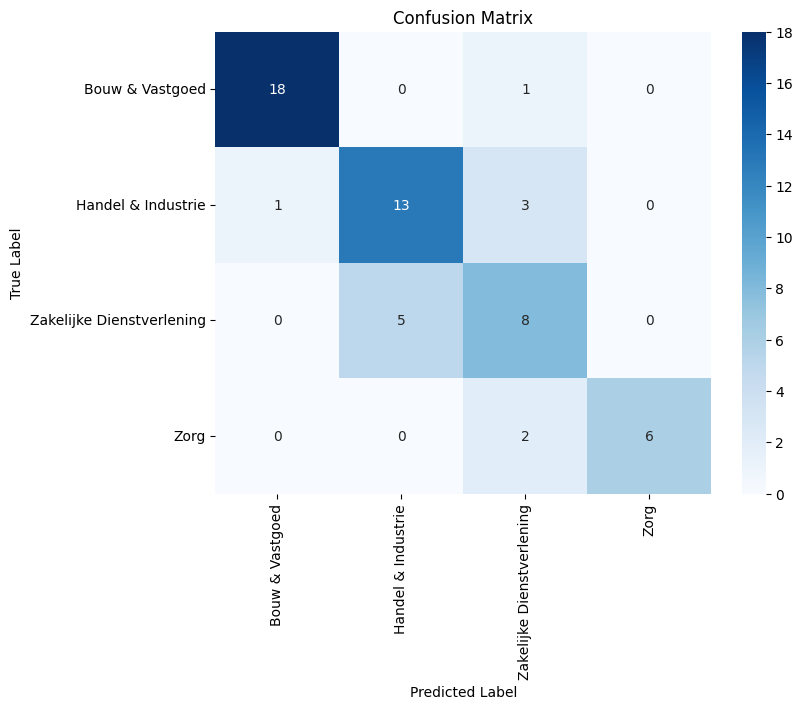

In [151]:
train_model(df=df_clean,
            model_type = "SVM", 
            testing_ratio = 0.15, 
            vectorization_within_folds = False, 
            show_class_accuracy = True, 
            show_confusion_matrix = True,
            k_values = [1,2,5,10,20])

Tuning NB classifier with a train/test split of 0.8/0.2 

K: 2, Alpha: 0.01, fit_prior: True, StratifiedKFold Score: 0.6835443037974683
K: 2, Alpha: 0.01, fit_prior: False, StratifiedKFold Score: 0.6645569620253164
K: 2, Alpha: 0.1, fit_prior: True, StratifiedKFold Score: 0.7088607594936709
K: 2, Alpha: 0.1, fit_prior: False, StratifiedKFold Score: 0.689873417721519
K: 2, Alpha: 0.5, fit_prior: True, StratifiedKFold Score: 0.620253164556962
K: 2, Alpha: 0.5, fit_prior: False, StratifiedKFold Score: 0.6835443037974683
K: 2, Alpha: 1.0, fit_prior: True, StratifiedKFold Score: 0.5569620253164557
K: 2, Alpha: 1.0, fit_prior: False, StratifiedKFold Score: 0.6708860759493671
K: 2, Alpha: 2.0, fit_prior: True, StratifiedKFold Score: 0.5506329113924051
K: 2, Alpha: 2.0, fit_prior: False, StratifiedKFold Score: 0.6075949367088608
K: 2, Alpha: 5.0, fit_prior: True, StratifiedKFold Score: 0.5569620253164557
K: 2, Alpha: 5.0, fit_prior: False, StratifiedKFold Score: 0.5506329113924051
K: 2, Alpha:

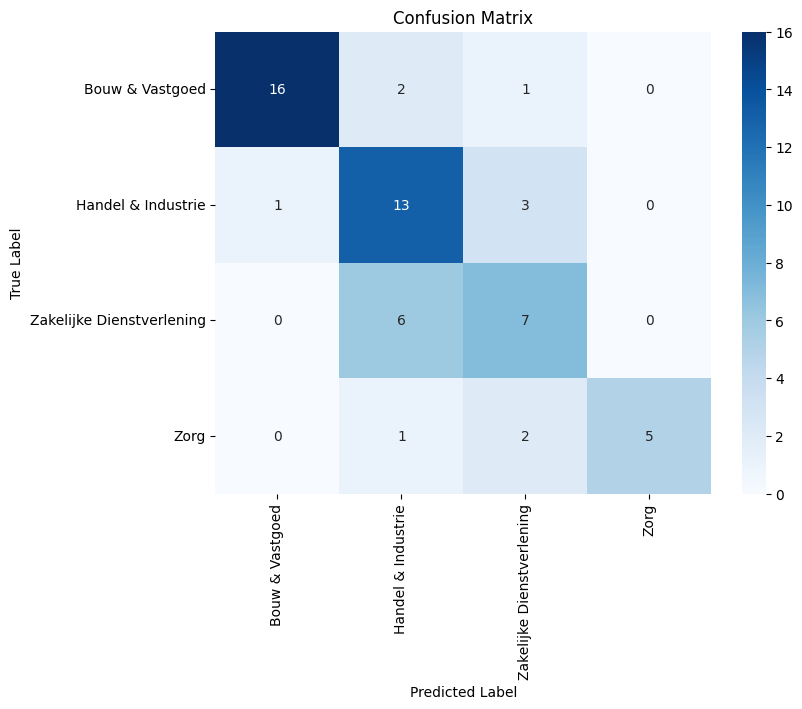

In [153]:
train_model(df=df_clean,
            model_type = "NB", 
            testing_ratio = 0.2, 
            vectorization_within_folds = True, 
            show_class_accuracy = True, 
            show_confusion_matrix = True,
           k_values = [2,12,15])

# Showing percentages per class

First for SVM classification

Now for Naive Bayes

In [142]:
#NOTE: i have noticed that test performance tends to be higher for k>1 even though the validation score would suggest that k=1 is best. 
#I think this is because stratified cross validation generalizes better.
#How do I decide on k? I can't run everything over test set, that would turn test set into 2nd validation set.